In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Edhec_risk_kit as erk

In [2]:
#Load the industry returns and the total market index we previously created
ind_return = erk.industry_dframe()
tmi_return = erk.industry_dframe_MarketSize()

In [3]:
#Risky Asset
risky_return = ind_return["2000":][["Steel","Fin","Beer"]]

In [4]:
#safe Asset
safe_return = pd.DataFrame().reindex_like(risky_return)

In [5]:
safe_return.shape

(228, 3)

In [6]:
safe_return[:] = 0.03/12 # 3% is my annual return for safe asset 

1. Cusion = (Asset value - Floor value)
2. Compute an allocation For safe and risky asset--->m*risky_alloctaion
3. Recompute the Asset value based on allocation

In [13]:
dates = risky_return.index
n_steps = len(dates)
account_value = 1000
floor = 0.8 # 0.8 means 80% of  account value will be considered as a floor value
floor_value = account_value * floor
m = 3 # m-->multiplier for CPPI
# History for looking at the changes at each step
account_history = pd.DataFrame().reindex_like(risky_return)
cusion_history = pd.DataFrame().reindex_like(risky_return)
risky_weight_history = pd.DataFrame().reindex_like(risky_return)
# CPPI Algo
for step in range(n_steps):
    cusion = (account_value-floor_value)/account_value
    risky_weight = m * cusion
    risky_weight = np.minimum(risky_weight,1)
    risky_weight = np.maximum(risky_weight,0)
    safe_weight = 1 - risky_weight
    risky_alloc = risky_weight * account_value
    safe_alloc = safe_weight * account_value
    # Update the account value For each time step
    account_value = risky_alloc * (1 + risky_return.iloc[step]) + safe_alloc * (1 + safe_return.iloc[step])
    # Save the value to a dataframe To look into it in future
    cusion_history.iloc[step] = cusion
    account_history.iloc[step] = account_value
    risky_weight_history.iloc[step] = risky_weight

In [14]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


In [16]:
account_history.sum(axis = "columns")

2000-01    2946.180000
2000-02    2877.431676
2000-03    2970.578459
2000-04    2956.000189
2000-05    2999.743274
              ...     
2018-08    7696.025323
2018-09    7651.411875
2018-10    7359.742510
2018-11    7647.976918
2018-12    6887.644531
Freq: M, Length: 228, dtype: float64

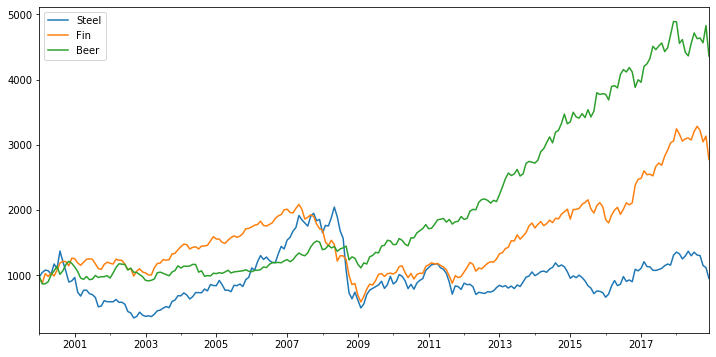

In [22]:
risky_wealth = 1000*(1+risky_return).cumprod()
risky_wealth.plot(figsize=(12,6))

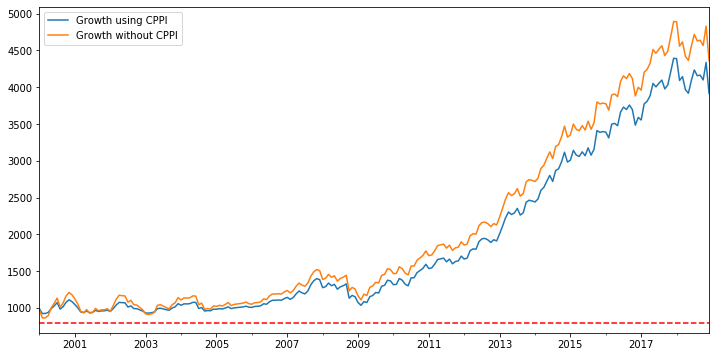

In [25]:
ax = account_history["Beer"].plot(figsize=(12,6),label = "Growth using CPPI",legend=True)
risky_wealth["Beer"].plot(ax=ax,label = "Growth without CPPI",legend=True)
ax.axhline(y = floor_value, color="red", linestyle="--")

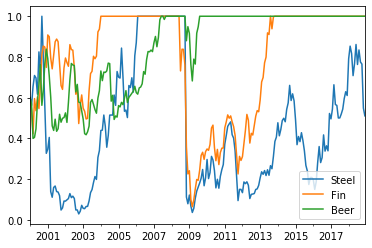

In [26]:
risky_weight_history.plot()

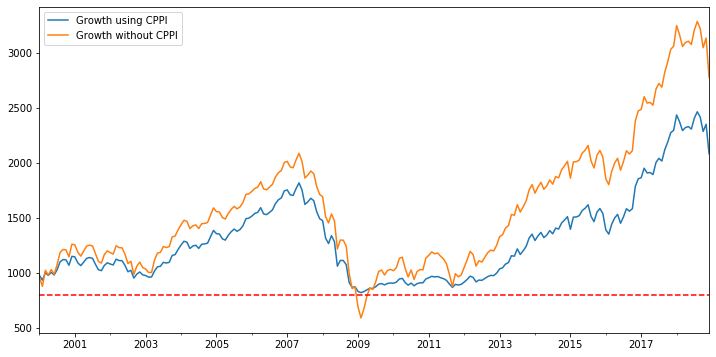

In [27]:
ind = "Fin"
ax = account_history[ind].plot(figsize=(12,6),label = "Growth using CPPI",legend=True)
risky_wealth[ind].plot(ax=ax,label = "Growth without CPPI",legend=True)
ax.axhline(y = floor_value, color="red", linestyle="--")

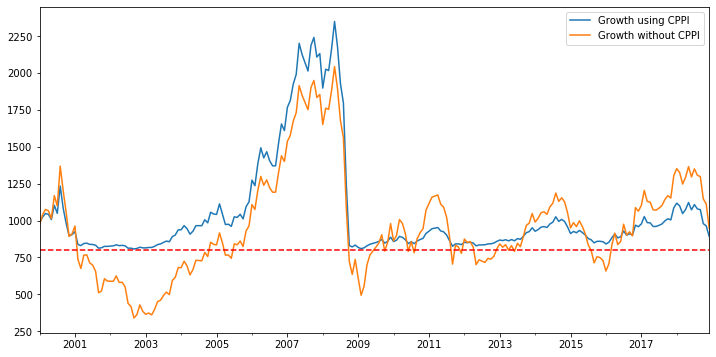

In [28]:
ind = "Steel"
ax = account_history[ind].plot(figsize=(12,6),label = "Growth using CPPI",legend=True)
risky_wealth[ind].plot(ax=ax,label = "Growth without CPPI",legend=True)
ax.axhline(y = floor_value, color="red", linestyle="--")

In [7]:
erk.summary_stats(risky_return)

,Annualized Return,Annualized Volatility,Sharp Ratio,Skewness,Kurtosis,Cornish-Fisher Var(5%),Historic CVar(5%),Max Drawdown
Steel,-0.002790,0.312368,-0.102567,-0.326334,4.144381,0.150499,-0.140580,-0.758017
Fin,0.055166,0.192909,0.126718,-0.533218,4.995534,0.091818,-0.090815,-0.718465
Beer,0.080598,0.138925,0.354314,-0.493545,4.173881,0.063382,-0.061100,-0.271368


In [8]:
btr = erk.CPPI(risky_return)
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Volatility,Sharp Ratio,Skewness,Kurtosis,Cornish-Fisher Var(5%),Historic CVar(5%),Max Drawdown
Steel,-0.005167,0.174180,-0.196750,-1.995143,17.110190,0.099498,-0.068080,-0.655198
Fin,0.040894,0.131678,0.080352,-0.946504,6.051414,0.066812,-0.053808,-0.549673
Beer,0.075544,0.115462,0.383772,-0.669250,4.760879,0.053482,-0.049275,-0.259582


### Drawdown Constraints

In [9]:
btr = erk.CPPI(ind_return["2007":][["Steel","Fin","Beer"]], drawdown=0.25)

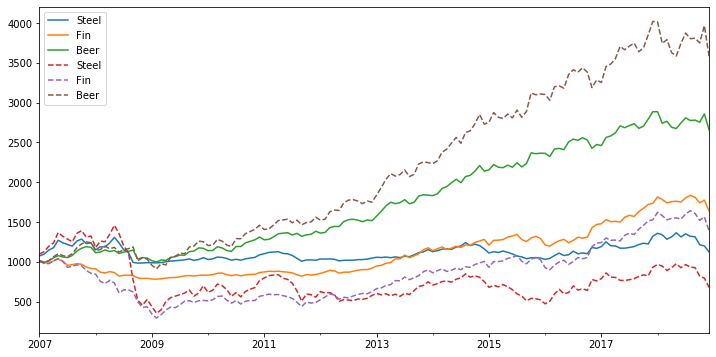

In [10]:
ax = btr["Wealth"].plot(figsize=(12,6))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [11]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Volatility,Sharp Ratio,Skewness,Kurtosis,Cornish-Fisher Var(5%),Historic CVar(5%),Max Drawdown
Steel,-0.039660,0.306407,-0.221642,-0.459951,4.782828,0.152988,-0.13198,-0.758017
Fin,0.027364,0.212204,-0.012370,-0.695200,4.621401,0.106852,-0.10610,-0.718465
Beer,0.111554,0.127971,0.620132,-0.670797,4.650878,0.057119,-0.04687,-0.271368


In [12]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Volatility,Sharp Ratio,Skewness,Kurtosis,Cornish-Fisher Var(5%),Historic CVar(5%),Max Drawdown
Steel,0.003784,0.097073,-0.262958,-0.441089,5.220481,0.047575,-0.043444,-0.248059
Fin,0.041975,0.085028,0.136964,-0.355163,4.153860,0.038458,-0.038201,-0.243626
Beer,0.084375,0.086263,0.613413,-0.744111,4.571533,0.038454,-0.031027,-0.161186
